In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import yfinance as yf

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression

In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("Adj Close") returns with lagged Yen futures returns.


In [2]:
# Futures contract on the dollar-Yen exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration

df = yf.download('USDJPY=X')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-10-30,114.370003,114.480003,113.610001,114.180000,114.180000,0
1996-11-01,113.500000,113.500000,113.500000,113.500000,113.500000,0
1996-11-04,113.279999,113.980003,112.949997,113.879997,113.879997,0
1996-11-05,113.709999,114.330002,113.449997,114.250000,114.250000,0
1996-11-06,114.230003,114.680000,113.650002,113.949997,113.949997,0
...,...,...,...,...,...,...
2022-11-11,141.733994,142.466003,138.888000,141.733994,141.733994,0
2022-11-14,139.552994,140.768997,138.869003,139.552994,139.552994,0
2022-11-15,140.115005,140.580994,137.809006,140.115005,140.115005,0


In [3]:
# Trim the dataset to begin on January 1st, 2000
df = df.loc["2000-01-01":, :]
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,102.070000,103.330002,101.309998,101.690002,101.690002,0
2000-01-04,101.639999,103.320000,101.470001,103.139999,103.139999,0
2000-01-05,103.129997,104.480003,102.750000,104.089996,104.089996,0
2000-01-06,104.089996,105.559998,103.900002,105.230003,105.230003,0
2000-01-07,105.260002,105.879997,104.830002,105.330002,105.330002,0


# Data Preparation
**Returns**

In [4]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
df['Return'] = (df[["Adj Close"]].pct_change() * 100)
returns = df.replace(-np.inf, np.nan).dropna()
returns.tail()

C:\Users\Owner\anaconda3\envs\CurrentMain\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2022-11-11,141.733994,142.466003,138.888000,141.733994,141.733994,0,-3.060691
2022-11-14,139.552994,140.768997,138.869003,139.552994,139.552994,0,-1.538798
2022-11-15,140.115005,140.580994,137.809006,140.115005,140.115005,0,0.402723
2022-11-16,138.964996,140.285004,138.893997,138.964996,138.964996,0,-0.820761
2022-11-17,140.259995,140.319000,140.166000,140.242004,140.242004,0,0.918942


# Lagged Returns

In [5]:
# Create a lagged return using the shift function
df['Lagged_Return'] = df["Return"].shift()
df = df.dropna()
df.tail()

C:\Users\Owner\anaconda3\envs\CurrentMain\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Close,Adj Close,Volume,Return,Lagged_Return
Date,,,,,,,,
2022-11-11,141.733994,142.466003,138.888000,141.733994,141.733994,0,-3.060691,0.629066
2022-11-14,139.552994,140.768997,138.869003,139.552994,139.552994,0,-1.538798,-3.060691
2022-11-15,140.115005,140.580994,137.809006,140.115005,140.115005,0,0.402723,-1.538798
2022-11-16,138.964996,140.285004,138.893997,138.964996,138.964996,0,-0.820761,0.402723
2022-11-17,140.259995,140.319000,140.166000,140.242004,140.242004,0,0.918942,-0.820761


# Train Test Split

In [6]:
# Create a train/test split for the data using 2018- current for testing and the rest for training
train = df[:'2017']
test = df['2018':]

In [7]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [8]:
X_train

,Lagged_Return
Date,
2000-01-05,1.425899
2000-01-06,0.921075
2000-01-07,1.095213
2000-01-10,0.095028
2000-01-11,-0.161396
...,...
2017-12-25,0.072413
2017-12-26,-0.013236
2017-12-27,-0.004410


# Linear Regression Model

In [9]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [10]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [11]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions

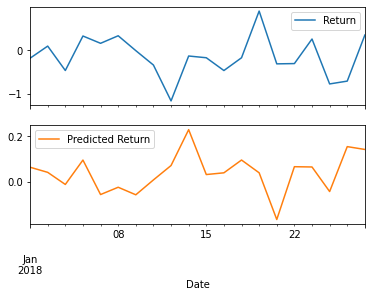

In [12]:
import matplotlib.pyplot as plt
# Plot the first 20 predictions vs the true values
prediction_plot=Results[:20].plot(subplots=True)
plt.savefig("Prediction_plot.png")

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)


In [13]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")



Out-of-Sample Root Mean Squared Error (RMSE): 0.4842346523518171


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)


In [14]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.7537994265289849


# Conclusions

The model has a root mean square error of 0.484% on out-of-sample data and 0.7535% on in-sample data. Hence, the model performs better with data that it has not worked with before.

The In-Sample data and the Out of Sample results is highly deviant from each other.
